In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torchaudio
from pathlib import Path
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from skopt import BayesSearchCV

from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Set random seed for reproducibility
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)

## Data Preparation and HuBERT Feature Extraction

In this section, we prepare the audio data and extract features using the HuBERT model for audio classification tasks. The steps include:

### Step 1: Preparing the Data

1. **Loading HuBERT Model**: We load the pre-trained HuBERT model from `torchaudio.pipelines.HUBERT_BASE`. HuBERT (Hidden-Unit BERT) is a model specifically designed for learning representations of speech audio. It uses a self-supervised learning approach to capture audio features that can be useful for downstream tasks like classification.

2. **Loading Audio Data**: 
   - We read the list of audio files and their corresponding metadata from a CSV file (`directory_w_train_test.csv`). This file contains information about the participants, labels, and whether each file belongs to the training or test set.
   - We filter the data to focus on a specific participant (P01) and select training files where the label has at least 30 instances. This ensures that the model is trained on labels with sufficient data for learning.

3. **Calculating Maximum Audio Length**: 
   - We compute the duration of each audio file in seconds and find the maximum length. This maximum length is later used to determine the padding length for audio signals, ensuring all input features have consistent dimensions.
   - The maximum length is also converted into samples using the sample rate of the HuBERT model. This is necessary because HuBERT requires inputs to be sampled at a specific rate.

### Step 2: Extracting HuBERT Features

1. **Resampling Audio**: 
   - Before feature extraction, each audio file is resampled to match the sample rate required by the HuBERT model (`bundle.sample_rate`). This step ensures compatibility with the pre-trained model and optimal feature extraction.

2. **Feature Extraction**: 
   - Using the HuBERT model, we extract features from the resampled audio signals. The model outputs a set of features for each audio file, capturing various aspects of the audio content.
   - To simplify the data, we take the mean of the extracted features across all frames (mean pooling), resulting in a fixed-size feature vector for each audio file.

3. **Preparing Labels**: 
   - The labels corresponding to each audio file are converted into numerical indices using a dictionary that maps each unique label to an integer. This transformation is required for training machine learning models, which typically operate on numerical inputs.

4. **Splitting Data**: 
   - The feature vectors and labels are split into training and testing sets using an 80:20 split, stratified by label to ensure balanced class representation in both sets. The `train_test_split` function from `sklearn` is used for this purpose.

This process prepares the audio data by extracting meaningful features with the HuBERT model and organizing them into train and test sets, ready for training a machine learning model.

In [3]:
# Step 1: Prepare Data

In [4]:
# Load HuBERT model and extract features
bundle = torchaudio.pipelines.HUBERT_BASE
hubert_model = bundle.get_model()

In [5]:
# List of data files
data_files = pd.read_csv("data/directory_w_train_test.csv")
data_files_p1 = data_files.loc[data_files.Participant == "P01"]
label_counts = data_files_p1.Label.value_counts()
training_files = data_files_p1.loc[
    data_files_p1.Label.isin(label_counts[label_counts >= 30].index)
    & (data_files_p1.is_test == 0)
]

In [6]:
# Load data
datadir = Path("data/wav")

In [7]:
# Calculate maximum length of the audio files in seconds
durations = []
for filename in training_files.Filename:
    signal, sample_rate = torchaudio.load(datadir / filename)
    durations.append(signal.size(1) / sample_rate)

max_length = max(durations)  # Maximum length in seconds

In [8]:
# Calculate maximum length in samples
max_length_samples = int(max_length * bundle.sample_rate)  # Convert to samples using HuBERT's sample rate

In [9]:
# Extract HuBERT features
datadir = Path("data/wav")
hubert_features = []
labels = []
for filename in tqdm(training_files.Filename):
    waveform, sample_rate = torchaudio.load(datadir / filename)
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    features, _ = hubert_model.extract_features(waveform)
    hubert_features.append(features[0].mean((0, 1)).detach().cpu().numpy())
    labels.append(training_files[training_files.Filename == filename].Label.values[0])

hubert_features = np.array(hubert_features)
labels = np.array(labels)

100%|██████████| 1337/1337 [02:28<00:00,  9.03it/s]


In [10]:
# Prepare labels
label_to_idx = {label: idx for idx, label in enumerate(np.unique(labels))}
y = np.array([label_to_idx[label] for label in labels])

In [11]:
# Split data for HuBERT features (unchanged)
X_train_hubert, X_test_hubert, y_train, y_test = train_test_split(hubert_features, y, test_size=0.2, stratify=y, random_state=42)

## Step 1.1: Load and Augment Mel Spectrogram Data

In this section, we focus on loading and augmenting mel spectrogram data to enhance the training set for audio classification. The process involves several data augmentation techniques to increase the robustness of the model. The steps include:

### Audio Data Augmentation

1. **Convert to Mono**: The function `convert_to_mono()` ensures that all audio signals are mono. If an audio file has two channels (stereo), the function averages these channels to create a mono signal, simplifying the data processing and reducing computational complexity.

2. **Padding Signals**: The function `pad_signal()` pads audio signals to a uniform length (`max_length_samples`). This ensures all input data has the same shape, which is crucial for batch processing in machine learning models.

3. **Shifting Signals**: The function `shift_signal()` shifts audio signals in time by a random amount up to 20% (`shift_max=0.2`) of the sample rate. This technique introduces temporal variations to the audio data, which can help the model generalize better by making it invariant to small shifts in the time dimension.

4. **Generating Mel Spectrograms**: The function `generate_mel_spectrogram()` computes the mel spectrogram of an audio signal using the Short-Time Fourier Transform (STFT). This transformation converts the audio signal into a 2D time-frequency representation that emphasizes the frequencies most relevant to human hearing.

5. **Masking Mel Spectrograms**: The function `mask_mel_spectrogram()` applies random masking to the mel spectrograms, both in the frequency and time domains. This data augmentation technique hides random parts of the spectrogram, forcing the model to learn more robust features and prevent overfitting:
   - **Frequency Masking**: Randomly masks out a portion of the frequency axis.
   - **Time Masking**: Randomly masks out a portion of the time axis.

6. **Augmenting Audio Files**: The function `augment_audio_files()` applies the above augmentation techniques to all audio files in the training set, generating augmented mel spectrograms. This augmentation process increases the diversity of the training data, helping the model generalize better to unseen data.

### Step 1.2: Padding Mel Spectrograms to Uniform Length

After generating augmented mel spectrograms, it is important to ensure all spectrograms have the same width (time dimension):

1. **Finding Maximum Length**: We calculate the maximum length (width) of the generated mel spectrograms across all training samples.

2. **Padding Spectrograms**: Each mel spectrogram is padded along the time axis to match the maximum width using `F.pad()`. This step ensures that all spectrograms have the same dimensions, which is necessary for batch processing in neural networks.

3. **Converting to Tensors**: The padded mel spectrograms are then converted to PyTorch tensors. This format is required for compatibility with PyTorch models and allows for efficient computation on the GPU.

### Splitting Augmented Mel Spectrogram Data

1. **Data Splitting**: The augmented and padded mel spectrogram data is split into training and testing sets using an 80:20 split. The split is stratified by label to ensure balanced class representation in both the training and testing datasets.

2. **Ensuring Correct Shape**: The data is checked and adjusted to ensure it has the correct shape for input into a PyTorch model. Specifically, it ensures that the mel spectrograms have the correct number of dimensions (batch size, channels, height, width).

This section prepares the mel spectrogram data by augmenting it with various techniques and padding it to a uniform length, making it ready for input into a neural network for training.

In [12]:
# Step 1.1: Load and Augment Mel Spectrogram Data
def convert_to_mono(signal):
    if signal.shape[0] == 2:  # If stereo, convert to mono
        signal = signal.mean(dim=0, keepdim=True)
    return signal

def pad_signal(signal, max_length_samples):
    if signal.size(1) < max_length_samples:
        pad = (0, max_length_samples - signal.size(1))
        signal = F.pad(signal, pad)
    return signal

def shift_signal(signal, sample_rate, shift_max=0.2):
    shift_amount = int(random.random() * shift_max * sample_rate)
    return signal.roll(shift_amount)

def generate_mel_spectrogram(signal, sample_rate, n_mels=128, fmin=0, fmax=None, n_fft=2048):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels, f_min=fmin, f_max=fmax, n_fft=n_fft)(signal)
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    return mel_spectrogram_db

def mask_mel_spectrogram(mel_spectrogram, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    n_mel_channels = mel_spectrogram.shape[1]
    n_mel_frames = mel_spectrogram.shape[2]
    
    max_mask_size_freq = int(max_mask_pct * n_mel_channels)
    max_mask_size_time = int(max_mask_pct * n_mel_frames)
    
    for _ in range(n_freq_masks):
        mask_size_freq = random.randint(0, max_mask_size_freq)
        mask_start_freq = random.randint(0, n_mel_channels - mask_size_freq)
        mel_spectrogram[:, mask_start_freq:mask_start_freq + mask_size_freq, :] = 0 

    for _ in range(n_time_masks):
        mask_size_time = random.randint(0, max_mask_size_time)
        mask_start_time = random.randint(0, n_mel_frames - mask_size_time)
        mel_spectrogram[:, :, mask_start_time:mask_start_time + mask_size_time] = 0

    return mel_spectrogram

def augment_audio_files(audio_files, max_length_samples, sample_rate, n_mels=128, fmin=0, fmax=None, n_fft=2048, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    mel_spectrograms = []
    augmented_audio_files = []
    
    for filename in tqdm(audio_files):
        signal, sr = torchaudio.load(datadir / filename)
        signal = convert_to_mono(signal)
        signal = pad_signal(signal, max_length_samples)
        signal = shift_signal(signal, sample_rate)
        
        augmented_audio_files.append(signal.numpy())
        
        mel_spectrogram = generate_mel_spectrogram(signal, sample_rate, n_mels, fmin, fmax, n_fft)
        mel_spectrogram = mask_mel_spectrogram(mel_spectrogram, max_mask_pct, n_freq_masks, n_time_masks)
        mel_spectrograms.append(mel_spectrogram)
    
    return mel_spectrograms, augmented_audio_files

In [13]:
# Generate augmented Mel spectrograms
mel_spectrograms, _ = augment_audio_files(training_files.Filename, max_length_samples, bundle.sample_rate)

100%|██████████| 1337/1337 [00:02<00:00, 541.57it/s]


In [14]:
# Step 1.2: Pad Mel Spectrograms to Same Length
# Find the maximum length (width) of the spectrograms
max_width = max(ms.shape[-1] for ms in mel_spectrograms)

In [15]:
# Pad all Mel spectrograms to this maximum length
mel_spectrograms_padded = []
for ms in mel_spectrograms:
    pad_width = max_width - ms.shape[-1]
    padded_ms = F.pad(ms, (0, pad_width))  # Pad only the time dimension
    mel_spectrograms_padded.append(padded_ms)

In [16]:
# Convert Mel spectrograms to tensors
mel_spectrograms_padded = torch.stack([ms.unsqueeze(0) for ms in mel_spectrograms_padded])

In [17]:
# Split Mel spectrogram data (updated to include augmentation)
X_train_mel, X_test_mel, y_train, y_test = train_test_split(mel_spectrograms_padded, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Ensure the Mel spectrogram data has the correct shape
X_train_mel = X_train_mel.squeeze(1) if X_train_mel.dim() == 5 else X_train_mel
X_test_mel = X_test_mel.squeeze(1) if X_test_mel.dim() == 5 else X_test_mel

## Step 2: Define Models for Audio Classification

In this section, we define two neural network models for audio classification using PyTorch: `HuBERTClassifier` and `MelSpectrogramClassifier`. Each model is designed to work with different types of input features extracted from audio data.

### 1. `HuBERTClassifier`

The `HuBERTClassifier` is a simple fully connected neural network designed to classify audio data using features extracted by the HuBERT model. Here’s a breakdown of its architecture:

- **Input Layer (`fc1`)**: 
  - A fully connected linear layer that takes the input dimension (`input_dim`) corresponding to the size of the HuBERT feature vector and maps it to 512 hidden units.
  - Activation Function: ReLU (Rectified Linear Unit) is applied after this layer to introduce non-linearity and help the network learn complex patterns in the data.
  
- **Output Layer (`fc2`)**:
  - Another fully connected layer that takes the 512-dimensional hidden representation and outputs `n_classes` nodes. Each node corresponds to a class in the classification task.
  - This layer outputs raw, unnormalized scores (logits) for each class, which are typically passed to a softmax function during training to convert them into probabilities.

#### Forward Pass (`forward` method):
The `forward` method defines how the input data flows through the network layers:
  1. The input `x` is passed through the first fully connected layer (`fc1`) and activated with ReLU.
  2. The output is then passed through the second fully connected layer (`fc2`), generating the final class logits.

### 2. `MelSpectrogramClassifier`

The `MelSpectrogramClassifier` is a convolutional neural network (CNN) designed to classify audio data using mel spectrograms as input. This model leverages convolutional layers to extract spatial hierarchies of features from the spectrograms. Here’s a breakdown of its architecture:

- **Convolutional Layers (`conv1` to `conv4`)**:
  - The model contains four convolutional layers with increasing numbers of output channels:
    - **`conv1`**: Takes a single-channel input (mel spectrogram) and outputs 32 feature maps.
    - **`conv2`**: Takes 32 input channels and outputs 64 feature maps.
    - **`conv3`**: Takes 64 input channels and outputs 128 feature maps.
    - **`conv4`**: Takes 128 input channels and outputs 256 feature maps.
  - Each convolutional layer uses a kernel size of 3x3, a stride of 1, and padding of 1 to preserve the input size. This setup allows the network to learn local patterns in the spectrogram, such as edges, textures, and other features.

- **Pooling Layers (`pool`)**:
  - A max pooling layer with a kernel size of 2x2 and stride 2 is applied after each convolutional layer to down-sample the feature maps by a factor of 2. This reduces the dimensionality of the data and helps the network learn more abstract features at each layer.

- **Global Average Pooling Layer (`global_avg_pool`)**:
  - After the convolutional layers, a global average pooling layer reduces each feature map to a single number by taking the average of all values. This layer reduces the model’s sensitivity to spatial translations of features in the input.

- **Fully Connected Layers (`fc1` and `fc2`)**:
  - **`fc1`**: A fully connected layer with 256 input features (output from the global average pooling) and 512 output features, followed by a ReLU activation.
  - **`fc2`**: The final output layer that maps the 512-dimensional input to `n_classes` output nodes, providing raw class scores (logits).

- **Dropout Layer (`dropout`)**:
  - A dropout layer with a dropout probability of 0.5 is used before the final fully connected layer to prevent overfitting by randomly setting half of the input units to zero during training.

#### Forward Pass (`forward` method):
The `forward` method defines the forward pass of the model:
  1. The input `x` is passed through each convolutional layer (`conv1` to `conv4`), followed by a ReLU activation and a max pooling layer (`pool`).
  2. After the convolutional layers, the output is passed through the global average pooling layer (`global_avg_pool`).
  3. The pooled output is flattened and passed through the fully connected layers (`fc1` and `fc2`), with a dropout layer applied before the final layer to reduce overfitting.
  4. The final output is a set of logits corresponding to each class.

### Summary

Both models are designed to handle different types of input features:
- **`HuBERTClassifier`** is a simple model that classifies audio data based on features extracted using the HuBERT model.
- **`MelSpectrogramClassifier`** is a more complex model that uses convolutional layers to learn from mel spectrograms, capturing spatial hierarchies of features and leveraging global pooling and dropout to prevent overfitting.

These models are crucial for building robust audio classification systems, each suited for different types of input features and tasks.

In [19]:
# Step 2: Define Models

In [20]:
class HuBERTClassifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(HuBERTClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
class MelSpectrogramClassifier(nn.Module):
    def __init__(self, n_classes):
        super(MelSpectrogramClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, n_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Ensure x has shape (batch_size, channels, height, width)
        if x.dim() == 5:
            x = x.squeeze(1)  # Remove the unnecessary channel dimension

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Step 3: Initialize Models, Criterion, Optimizer, and Scheduler

In this section, we initialize the models, define the loss function, set up the optimizers, and configure learning rate schedulers. These components are essential for training the neural networks effectively.

### 1. Number of Classes (`n_classes`)

- **`n_classes`**: The number of unique classes in the dataset, which is calculated using the `np.unique(y)` function. This value is used to define the output layer size for both classifiers, ensuring they produce the correct number of logits corresponding to the class probabilities.

### 2. Device Configuration (`device`)

- **Device Selection**: The code checks if a GPU is available (`torch.cuda.is_available()`). If it is, it sets the device to `cuda` (GPU); otherwise, it defaults to `cpu`. Using a GPU accelerates the training process by leveraging parallel computation, especially useful for deep learning tasks with large datasets or complex models.

### 3. Model Initialization

Two models are initialized, each tailored to different feature sets extracted from the audio data:

- **`HuBERTClassifier`**:
  - **Input Dimension (`input_dim=768`)**: This parameter corresponds to the size of the feature vector output by the HuBERT model. The input dimension is crucial for defining the input layer of the fully connected network.
  - **`n_classes`**: Specifies the number of output nodes in the final layer, matching the number of unique labels in the dataset. 
  - **`to(device)`**: Moves the model to the specified device (GPU or CPU), ensuring that all computations during training and evaluation are performed on the chosen hardware.

- **`MelSpectrogramClassifier`**:
  - **`n_classes`**: Similar to `HuBERTClassifier`, this parameter defines the output layer size of the convolutional network, ensuring it outputs logits for each class.
  - **`to(device)`**: Moves the model to the specified device (GPU or CPU).

### 4. Loss Function (`criterion`)

- **`nn.CrossEntropyLoss()`**: This criterion is used as the loss function for training both models. Cross-entropy loss is commonly used for classification tasks as it measures the difference between the predicted probability distribution and the true distribution (one-hot encoded labels). The optimizer aims to minimize this loss during training, improving model accuracy.

### 5. Optimizers (`optimizer_hubert` and `optimizer_mel`)

- **Adam Optimizer (`torch.optim.Adam`)**:
  - **`optimizer_hubert`**: Configured for the `HuBERTClassifier` model with a learning rate (`lr`) of 0.001.
  - **`optimizer_mel`**: Configured for the `MelSpectrogramClassifier` model with the same learning rate.
  - **Learning Rate (`lr=0.001`)**: Specifies the step size for updating model parameters during training. A learning rate of 0.001 is a common choice, balancing the trade-off between convergence speed and stability.

### 6. Learning Rate Schedulers (`scheduler_hubert` and `scheduler_mel`)

- **`ReduceLROnPlateau` Scheduler**: This scheduler reduces the learning rate when a metric (in this case, validation loss) has stopped improving:
  - **`optimizer_hubert` Scheduler**: Monitors the validation loss of the `HuBERTClassifier` model and reduces the learning rate by a factor of 0.1 if the loss does not improve for 5 epochs (`patience=5`).
  - **`optimizer_mel` Scheduler**: Performs the same function for the `MelSpectrogramClassifier` model.
  - **Parameters**:
    - **`mode='min'`**: The scheduler monitors for a minimum in the validation loss.
    - **`factor=0.1`**: The factor by which the learning rate is reduced when the scheduler is triggered.
    - **`patience=5`**: The number of epochs to wait for improvement before reducing the learning rate.
    - **`verbose=True`**: Enables logging of learning rate updates for better monitoring during training.

### Summary

This setup ensures both models (`HuBERTClassifier` and `MelSpectrogramClassifier`) are correctly initialized with appropriate parameters and training configurations. The choice of loss function, optimizers, and learning rate schedulers is tailored to optimize model performance, making the training process efficient and adaptive to learning progress.


In [22]:
# Step 3: Initialize Models, Criterion, Optimizer, and Scheduler

In [23]:
n_classes = len(np.unique(y))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hubert_model = HuBERTClassifier(input_dim=768, n_classes=n_classes).to(device)
mel_model = MelSpectrogramClassifier(n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hubert = torch.optim.Adam(hubert_model.parameters(), lr=0.001)
optimizer_mel = torch.optim.Adam(mel_model.parameters(), lr=0.001)

scheduler_hubert = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_hubert, mode='min', factor=0.1, patience=5, verbose=True)
scheduler_mel = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mel, mode='min', factor=0.1, patience=5, verbose=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Step 4: Train the Models

In this section, we define the function to train the models and execute the training process for the HuBERT-based model. The training process involves several key steps, including forward and backward passes, loss computation, optimization, and evaluation.

### Training Function: `train_model`

The `train_model` function handles the training and evaluation of a PyTorch model. It takes several inputs: the model, loss function (`criterion`), optimizer, learning rate scheduler, number of epochs (`n_epochs`), training data loader (`train_loader`), validation data loader (`val_loader`), and the device (CPU or GPU).

#### Key Steps in `train_model`:

1. **Model Preparation**: 
   - The model is moved to the specified device (CPU or GPU) using `model.to(device)`. This ensures that all computations during training and evaluation are performed on the appropriate hardware.

2. **Training Loop**: 
   - The training loop runs for a specified number of epochs (`n_epochs`). Each epoch involves a pass through the entire training dataset, updating model parameters based on the computed gradients.

   - **Training Mode**: The model is set to training mode using `model.train()`, enabling certain layers (like dropout and batch normalization) to function correctly during training.

   - **Batch Processing**:
     - For each batch of data (`X, y`) in the training data loader (`train_loader`), the following steps are executed:
       - **Move Data to Device**: Both inputs (`X`) and labels (`y`) are moved to the specified device.
       - **Zero Gradients**: The gradients are zeroed using `optimizer.zero_grad()` to prevent accumulation from previous batches.
       - **Forward Pass**: The input data (`X`) is passed through the model to obtain predictions (`y_pred`).
       - **Loss Calculation**: The loss is computed by comparing the predicted labels (`y_pred`) and the true labels (`y`) using the specified loss function (`criterion`).
       - **Backward Pass**: The gradients of the loss with respect to the model parameters are computed using `loss.backward()`.
       - **Optimizer Step**: The optimizer updates the model parameters based on the computed gradients using `optimizer.step()`.

   - **Metrics Calculation**:
     - The training loss and accuracy are accumulated over all batches. After the epoch, they are averaged by dividing by the number of samples in the dataset.

3. **Validation Loop**: 
   - After each training epoch, the model is evaluated on the validation dataset to monitor its performance on unseen data.

   - **Evaluation Mode**: The model is set to evaluation mode using `model.eval()`, disabling dropout and batch normalization layers to ensure consistent behavior during evaluation.

   - **Batch Processing**:
     - For each batch of data (`X, y`) in the validation data loader (`val_loader`), predictions (`y_pred`) are made and compared against the true labels (`y`). The validation loss and accuracy are accumulated and averaged across all batches.

4. **Logging and Scheduler Step**:
   - After each epoch, the training and validation metrics (loss and accuracy) are printed. 
   - The learning rate scheduler (`scheduler.step(val_loss)`) is updated based on the validation loss. This scheduler reduces the learning rate if the validation loss does not improve for a specified number of epochs, helping to fine-tune the model's learning process.

### Training the HuBERT Model

The HuBERT-based model is trained using the `train_model` function with the following configuration:

1. **Data Loaders**:
   - **`train_loader`**: A data loader for the training set, which batches and shuffles the HuBERT features and corresponding labels.
   - **`val_loader`**: A data loader for the validation set, which batches the HuBERT features and labels without shuffling.

2. **Training Configuration**:
   - **Model**: `hubert_model`, a classifier built on top of HuBERT features.
   - **Criterion**: Cross-entropy loss, suitable for multi-class classification tasks.
   - **Optimizer**: Adam optimizer with a learning rate of 0.001.
   - **Scheduler**: A learning rate scheduler that reduces the learning rate on plateauing validation loss.
   - **Number of Epochs**: 40 epochs, allowing the model sufficient time to learn from the data.

The training process is initiated by calling `train_model()` with the specified parameters. This setup ensures that the model is trained effectively, balancing learning speed and stability through the use of appropriate optimizers and learning rate schedulers.

In [24]:
# Step 4: Train the Models

In [25]:
def train_model(model, criterion, optimizer, scheduler, n_epochs, train_loader, val_loader, device):
    model.to(device)
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X)
                
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += (y_pred.argmax(1) == y).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        
        with torch.no_grad():
            for i, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                
                loss = criterion(y_pred, y)
                val_loss += loss.item()
                val_acc += (y_pred.argmax(1) == y).sum().item()
            
            val_loss /= len(val_loader.dataset)
            val_acc /= len(val_loader.dataset)
        
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.5f}")
        scheduler.step(val_loss)

In [26]:
# Train HuBERT Model
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_hubert).float(), torch.tensor(y_train).long()), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_test_hubert).float(), torch.tensor(y_test).long()), batch_size=32, shuffle=False)

In [27]:
train_model(hubert_model, criterion, optimizer_hubert, scheduler_hubert, n_epochs=40, train_loader=train_loader, val_loader=val_loader, device=device)

Epoch: 0 | Train Loss: 0.05251 | Train Acc: 0.34892 | Val Loss: 0.04844 | Val Acc: 0.45522
Epoch: 1 | Train Loss: 0.04293 | Train Acc: 0.46305 | Val Loss: 0.04088 | Val Acc: 0.55970
Epoch: 2 | Train Loss: 0.03724 | Train Acc: 0.56314 | Val Loss: 0.03540 | Val Acc: 0.61940
Epoch: 3 | Train Loss: 0.03320 | Train Acc: 0.62395 | Val Loss: 0.03296 | Val Acc: 0.63433


Epoch: 4 | Train Loss: 0.02994 | Train Acc: 0.66604 | Val Loss: 0.03034 | Val Acc: 0.67164
Epoch: 5 | Train Loss: 0.02748 | Train Acc: 0.70253 | Val Loss: 0.02933 | Val Acc: 0.67164
Epoch: 6 | Train Loss: 0.02559 | Train Acc: 0.71094 | Val Loss: 0.02697 | Val Acc: 0.71642
Epoch: 7 | Train Loss: 0.02436 | Train Acc: 0.73714 | Val Loss: 0.02551 | Val Acc: 0.72388
Epoch: 8 | Train Loss: 0.02257 | Train Acc: 0.75959 | Val Loss: 0.02501 | Val Acc: 0.73134
Epoch: 9 | Train Loss: 0.02161 | Train Acc: 0.77268 | Val Loss: 0.02628 | Val Acc: 0.70149
Epoch: 10 | Train Loss: 0.02152 | Train Acc: 0.75678 | Val Loss: 0.02371 | Val Acc: 0.74627
Epoch: 11 | Train Loss: 0.02059 | Train Acc: 0.77549 | Val Loss: 0.02503 | Val Acc: 0.70896
Epoch: 12 | Train Loss: 0.02025 | Train Acc: 0.77549 | Val Loss: 0.02342 | Val Acc: 0.75000
Epoch: 13 | Train Loss: 0.01855 | Train Acc: 0.80168 | Val Loss: 0.02297 | Val Acc: 0.75373
Epoch: 14 | Train Loss: 0.01833 | Train Acc: 0.79701 | Val Loss: 0.02341 | Val Acc: 0.

## Training the Mel Spectrogram Model

In this section, we train the Mel Spectrogram-based model (`MelSpectrogramClassifier`) using a similar approach to the HuBERT model but with mel spectrogram features as input. This model leverages convolutional layers to extract spatial patterns from the spectrograms, which are crucial for audio classification tasks.

### Data Loaders for Mel Spectrogram Model

- **Training Data Loader (`train_loader_mel`)**:
  - **Input**: The training data loader is created using the augmented mel spectrograms (`X_train_mel`) and corresponding labels (`y_train`).
  - **Batch Size**: Set to 32, meaning 32 samples are processed in each batch during training.
  - **Shuffle**: Set to `True` to shuffle the dataset before each epoch, ensuring that the model does not learn any unintended order-dependent patterns.

- **Validation Data Loader (`val_loader_mel`)**:
  - **Input**: The validation data loader is created using the mel spectrograms (`X_test_mel`) and corresponding labels (`y_test`).
  - **Batch Size**: Also set to 32.
  - **Shuffle**: Set to `False` as shuffling is not needed during validation, where the aim is to evaluate the model's performance on unseen data in a consistent order.

### Training Configuration for Mel Spectrogram Model

The training of the `MelSpectrogramClassifier` is conducted using the `train_model` function defined earlier, with the following configuration:

1. **Model**: `mel_model`, an instance of `MelSpectrogramClassifier` designed to handle mel spectrogram input features and learn audio classification tasks through a series of convolutional and fully connected layers.

2. **Criterion**: The loss function remains cross-entropy loss (`nn.CrossEntropyLoss()`), appropriate for multi-class classification problems.

3. **Optimizer**: `optimizer_mel` is the Adam optimizer (`torch.optim.Adam`) configured for `mel_model` with a learning rate (`lr`) of 0.001. The Adam optimizer is well-suited for this task due to its adaptive learning rate capabilities, helping to accelerate convergence.

4. **Scheduler**: `scheduler_mel` is a learning rate scheduler (`torch.optim.lr_scheduler.ReduceLROnPlateau`) that reduces the learning rate when the validation loss plateaus. This helps to fine-tune the learning process, especially when the model stops improving.

5. **Number of Epochs**: Set to 70 epochs for the `mel_model`, providing ample opportunity for the model to learn from the data. This is more than the HuBERT model's 40 epochs, reflecting the potentially more complex patterns in mel spectrograms that the convolutional layers need to capture.

### Training the Mel Spectrogram Model

The training process is initiated by calling the `train_model` function with the above configurations:

- **`train_loader_mel`** and **`val_loader_mel`**: Data loaders for training and validation sets of mel spectrograms.
- **`mel_model`**: The convolutional model for mel spectrogram classification.
- **Training and Validation Process**: Similar to the HuBERT model, the training process involves:
  - **Training Phase**: The model learns by adjusting its weights to minimize the loss on the training data.
  - **Validation Phase**: The model's performance is evaluated on a separate validation set to monitor overfitting and generalization capability.
  - **Metrics**: Training and validation loss and accuracy are printed for each epoch to provide insights into the model's learning progress.
  - **Learning Rate Adjustment**: Controlled by the learning rate scheduler based on validation loss, helping to prevent overfitting and ensuring efficient training.

This structured training approach aims to optimize the model's ability to classify audio data based on mel spectrogram features, leveraging the strengths of convolutional neural networks in capturing spatial hierarchies and patterns.

In [28]:
# Train Mel Spectrogram Model
train_loader_mel = DataLoader(TensorDataset(X_train_mel, torch.tensor(y_train).long()), batch_size=32, shuffle=True)
val_loader_mel = DataLoader(TensorDataset(X_test_mel, torch.tensor(y_test).long()), batch_size=32, shuffle=False)

In [29]:
train_model(mel_model, criterion, optimizer_mel, scheduler_mel, n_epochs=70, train_loader=train_loader_mel, val_loader=val_loader_mel, device=device)

Epoch: 0 | Train Loss: 0.05758 | Train Acc: 0.31244 | Val Loss: 0.05992 | Val Acc: 0.33209
Epoch: 1 | Train Loss: 0.05678 | Train Acc: 0.31338 | Val Loss: 0.05961 | Val Acc: 0.33209
Epoch: 2 | Train Loss: 0.05594 | Train Acc: 0.33302 | Val Loss: 0.05928 | Val Acc: 0.33209
Epoch: 3 | Train Loss: 0.05587 | Train Acc: 0.32367 | Val Loss: 0.05829 | Val Acc: 0.33209
Epoch: 4 | Train Loss: 0.05409 | Train Acc: 0.32460 | Val Loss: 0.05955 | Val Acc: 0.33209
Epoch: 5 | Train Loss: 0.05416 | Train Acc: 0.32460 | Val Loss: 0.05591 | Val Acc: 0.34328
Epoch: 6 | Train Loss: 0.05318 | Train Acc: 0.32928 | Val Loss: 0.05655 | Val Acc: 0.33209
Epoch: 7 | Train Loss: 0.05144 | Train Acc: 0.34425 | Val Loss: 0.05407 | Val Acc: 0.37313
Epoch: 8 | Train Loss: 0.04996 | Train Acc: 0.37231 | Val Loss: 0.05489 | Val Acc: 0.36940
Epoch: 9 | Train Loss: 0.04748 | Train Acc: 0.39383 | Val Loss: 0.05129 | Val Acc: 0.37687
Epoch: 10 | Train Loss: 0.04538 | Train Acc: 0.42189 | Val Loss: 0.04968 | Val Acc: 0.4141

## Visualizing the Model's Filters, Feature Maps, Activations, and Weights

This section is dedicated to visualizing various aspects of the `MelSpectrogramClassifier` model to gain deeper insights into its learned representations and internal workings. Understanding these visualizations can provide valuable feedback for refining the model and improving its performance.

### 1. Visualizing Convolutional Filters

Convolutional filters are the core components of a Convolutional Neural Network (CNN). They learn to detect various patterns and features from the input data. Visualizing these filters can help us understand what the network is learning at different layers.

#### Function: `plot_conv_filters`

- **Purpose**: This function plots the filters (weights) of a given convolutional layer.
- **Parameters**:
  - **`layer`**: The convolutional layer whose filters are to be visualized.
  - **`title`**: The title for the plot, typically indicating which layer's filters are being visualized.
- **Details**:
  - The filters are extracted from the layer's weight tensor.
  - A grid size is determined based on the number of filters, ensuring all filters are displayed in a square or nearly square grid.
  - Filters are plotted using a colormap (viridis) for better visual differentiation.
  - Unused subplots are removed to keep the plot clean.
  
**Usage**:
- **`plot_conv_filters(mel_model.conv1, 'Filters of conv1')`**: Visualizes the filters of the first convolutional layer (`conv1`).
- This process is repeated for the subsequent convolutional layers (`conv2`, `conv3`, and `conv4`).

### 2. Visualizing Feature Maps

Feature maps are the outputs of convolutional layers after applying filters to the input data. They represent the activation of different features learned by the filters.

#### Function: `plot_feature_maps`

- **Purpose**: This function plots the feature maps produced by a convolutional layer for a given input.
- **Parameters**:
  - **`feature_maps`**: The feature maps to be visualized.
  - **`title`**: The title for the plot, typically indicating which layer's feature maps are being visualized.
- **Details**:
  - The function extracts each feature map and plots it using a colormap (viridis).
  - A grid layout is used to display all feature maps in one figure.

### 3. Visualizing Activations

Activations refer to the output of neurons after applying the activation function (e.g., ReLU) in a layer. Visualizing activations can help understand which parts of the input data the model focuses on at different layers.

#### Function: `visualize_activations`

- **Purpose**: This function visualizes the activations of both convolutional and fully connected layers for a given input.
- **Parameters**:
  - **`model`**: The neural network model whose activations are to be visualized.
  - **`input_data`**: A batch of input data to feed through the model.
- **Details**:
  - The function performs a forward pass through the model in evaluation mode (`model.eval()`), ensuring no gradients are computed.
  - Activations are captured at each convolutional and fully connected layer.
  - Activations are visualized using heatmaps, where the intensity of color represents the magnitude of activation for each neuron.
  
**Example**:
- **`visualize_activations(mel_model, input_data)`**: Visualizes the activations of the `mel_model` for a sample batch of input data from `train_loader_mel`.

### 4. Visualizing Layer Weights

Visualizing the distribution of weights in fully connected layers can help diagnose potential issues such as vanishing or exploding gradients.

#### Function: `plot_layer_weights`

- **Purpose**: This function plots the distribution of weights in a fully connected layer.
- **Parameters**:
  - **`layer`**: The fully connected layer whose weights are to be visualized.
  - **`title`**: The title for the plot, indicating which layer's weights are being visualized.
- **Details**:
  - The weights are extracted and flattened into a 1D array.
  - A histogram is plotted to show the distribution of weight values.

**Usage**:
- **`plot_layer_weights(mel_model.fc1, 'Weight Distribution of fc1')`**: Visualizes the weight distribution of the first fully connected layer (`fc1`).
- This process is repeated for the second fully connected layer (`fc2`).

### Summary

These visualizations provide valuable insights into the internal workings of the neural network model:
- **Filters**: Help understand what patterns the model is learning at different layers.
- **Feature Maps**: Show how the input data is transformed as it passes through each layer.
- **Activations**: Indicate which neurons are active for a given input, revealing the model's focus and decision-making process.
- **Weights**: Allow monitoring of the weight distribution to detect potential training issues.

Understanding these visualizations can guide further model refinement and optimization, ultimately improving the model's performance on the task.

In [30]:
def plot_conv_filters(layer, title):
    filters = layer.weight.data.cpu().numpy()
    num_filters = filters.shape[0]
    
    # Plot each filter
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 15))
    for i in range(num_filters):
        ax = axes[i]
        filter = filters[i, 0, :, :]
        ax.imshow(filter, cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [44]:
def plot_conv_filters(layer, title):
    filters = layer.weight.data.cpu().numpy()
    num_filters = filters.shape[0]

    # Determine the grid size for plotting
    grid_size = int(np.ceil(np.sqrt(num_filters)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    for i in range(num_filters):
        row = i // grid_size
        col = i % grid_size
        ax = axes[row, col]
        filter = filters[i, 0, :, :]
        ax.imshow(filter, cmap='viridis')
        ax.axis('off')
    
    # Turn off any unused subplots
    for i in range(num_filters, grid_size**2):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

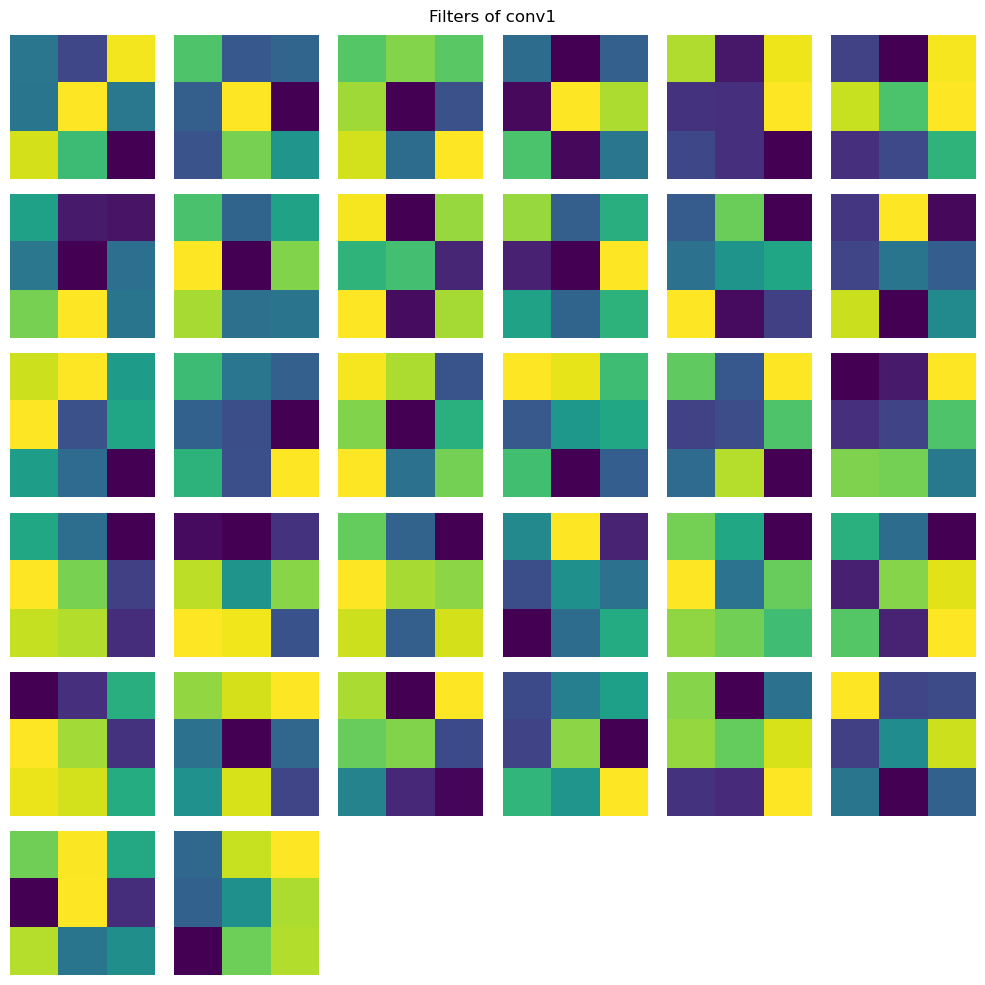

In [45]:
# Visualize filters of conv1
plot_conv_filters(mel_model.conv1, 'Filters of conv1')

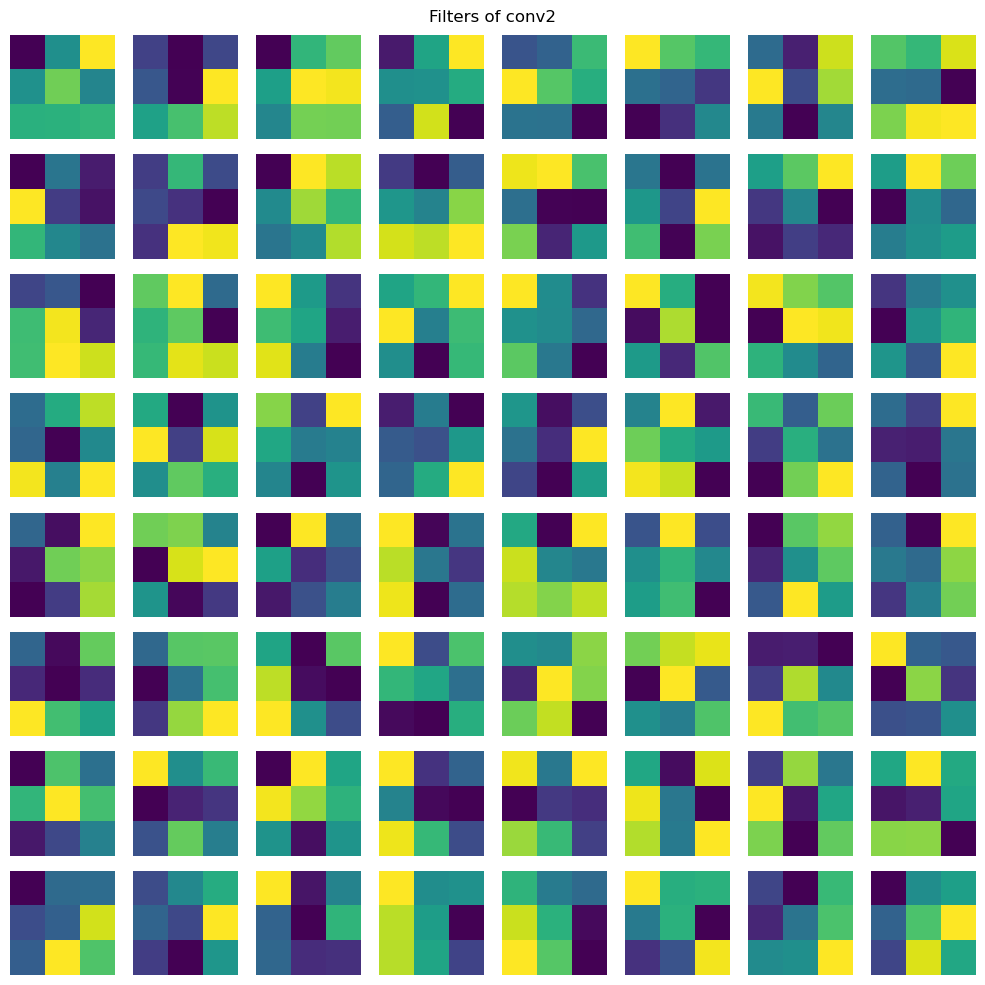

In [46]:
plot_conv_filters(mel_model.conv2, 'Filters of conv2')

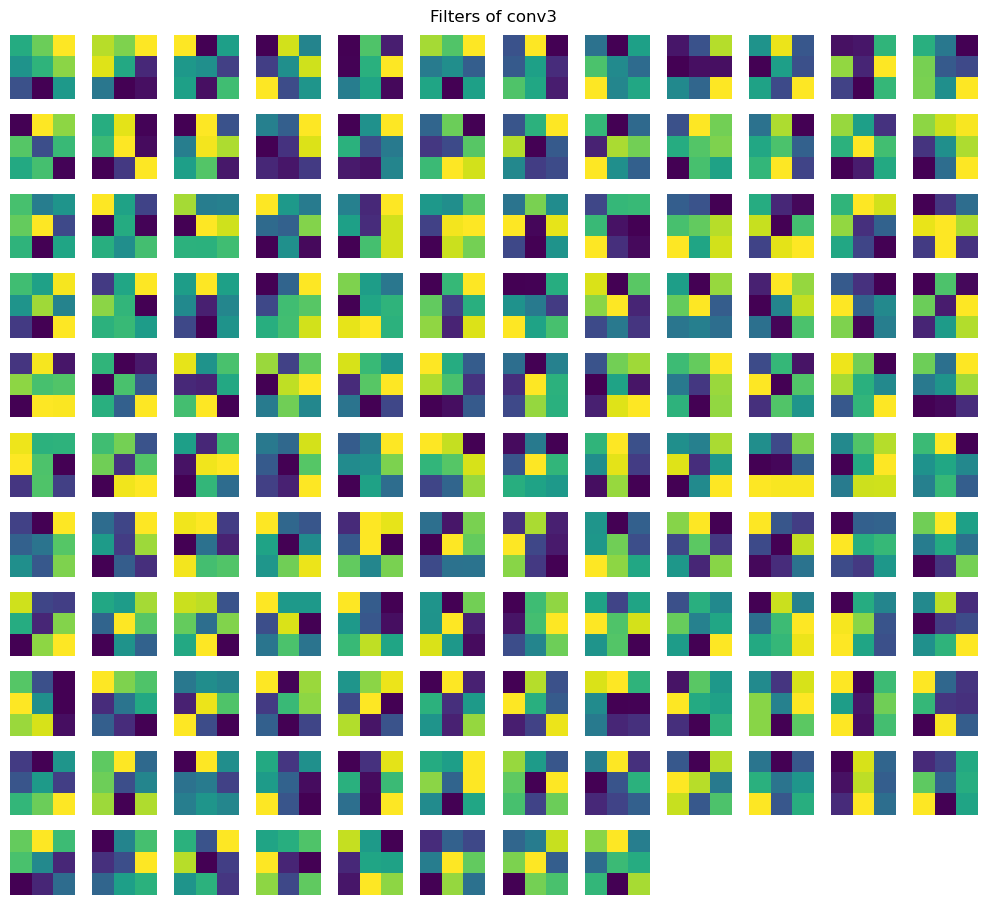

In [47]:
# Visualize filters of conv1
plot_conv_filters(mel_model.conv3, 'Filters of conv3')

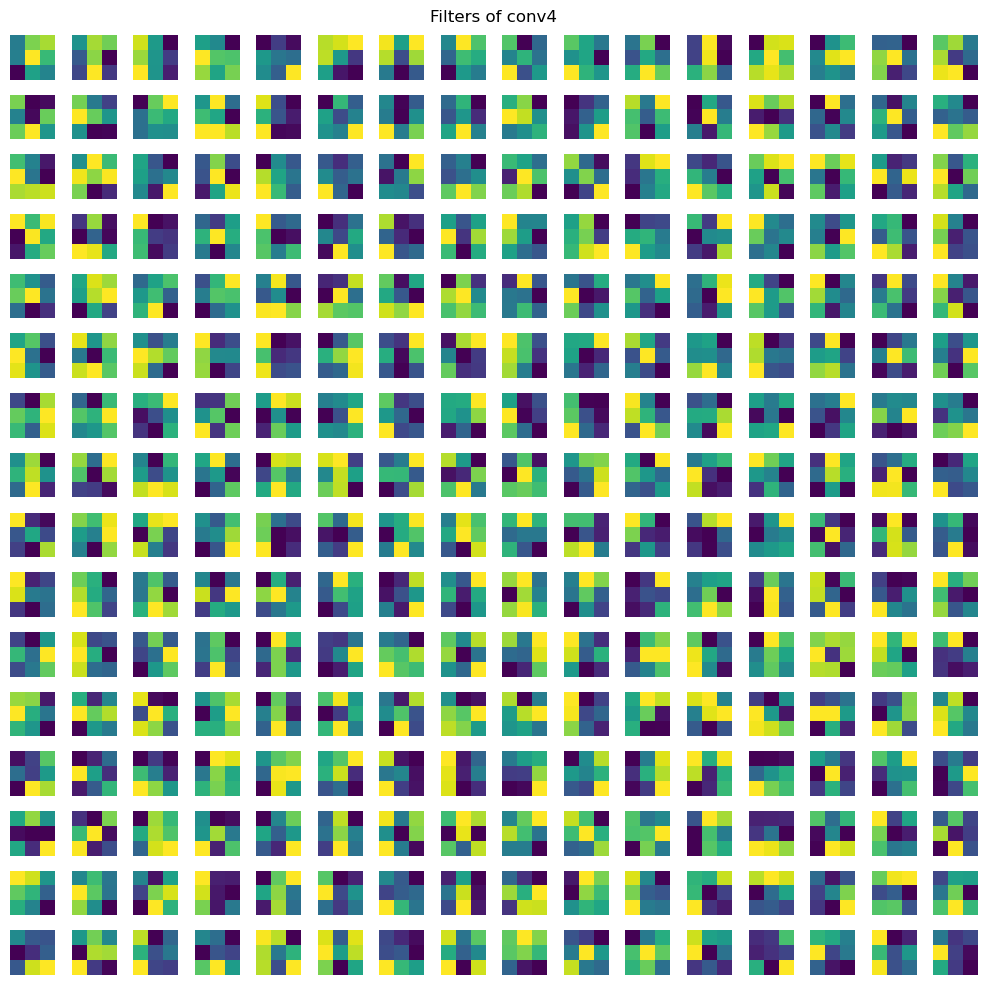

In [48]:
# Visualize filters of conv1
plot_conv_filters(mel_model.conv4, 'Filters of conv4')

In [35]:
def plot_feature_maps(feature_maps, title):
    num_feature_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 20))
    for i in range(num_feature_maps):
        ax = axes[i]
        ax.imshow(feature_maps[0, i, :, :].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [42]:
def visualize_activations(model, input_data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        x = F.relu(model.conv1(input_data))
        x = model.pool(x)
        x = F.relu(model.conv2(x))
        x = model.pool(x)
        x = F.relu(model.conv3(x))
        x = model.pool(x)
        x = F.relu(model.conv4(x))
        x = model.pool(x)
        x = model.global_avg_pool(x)  # Output size will be (batch_size, 256, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, 256)

        # Now, pass through fully connected layers
        fc1_activations = F.relu(model.fc1(x)).cpu().numpy()  # Output will be (batch_size, 512)
        fc2_activations = model.fc2(F.relu(model.fc1(x))).cpu().numpy()  # Output will be (batch_size, n_classes)
    
    # Plot activations
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(fc1_activations, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Activations of fc1')
    plt.xlabel('Neurons')
    plt.ylabel('Input Samples')

    plt.subplot(1, 2, 2)
    plt.imshow(fc2_activations, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Activations of fc2')
    plt.xlabel('Neurons')
    plt.ylabel('Input Samples')

    plt.tight_layout()
    plt.show()

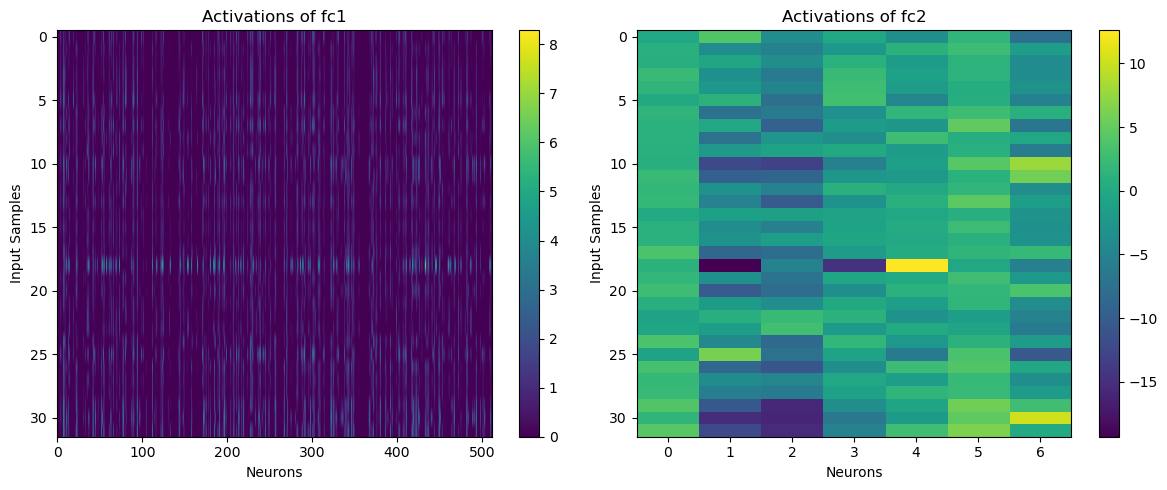

In [43]:
# Example input data from your DataLoader
data_iter = iter(train_loader_mel)
input_data, _ = next(data_iter)
input_data = input_data.to(device)

# Visualize activations
visualize_activations(mel_model, input_data)

In [36]:
def plot_layer_weights(layer, title):
    weights = layer.weight.data.cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.hist(weights.flatten(), bins=50, alpha=0.75, color='b')
    plt.title(title)
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')
    plt.show()

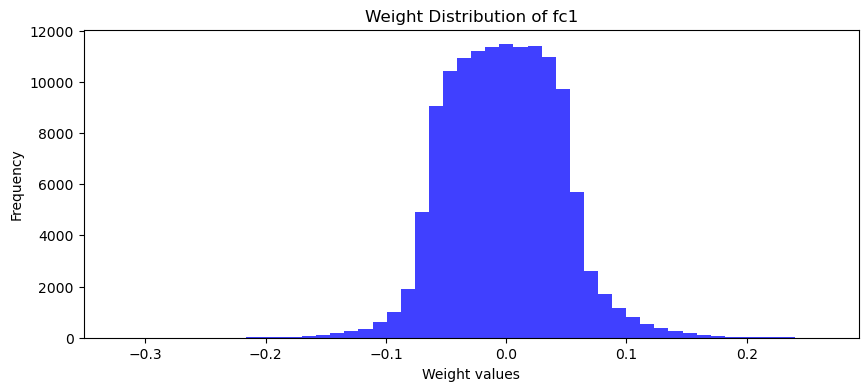

In [38]:
# Visualize weights of fc1
plot_layer_weights(mel_model.fc1, 'Weight Distribution of fc1')

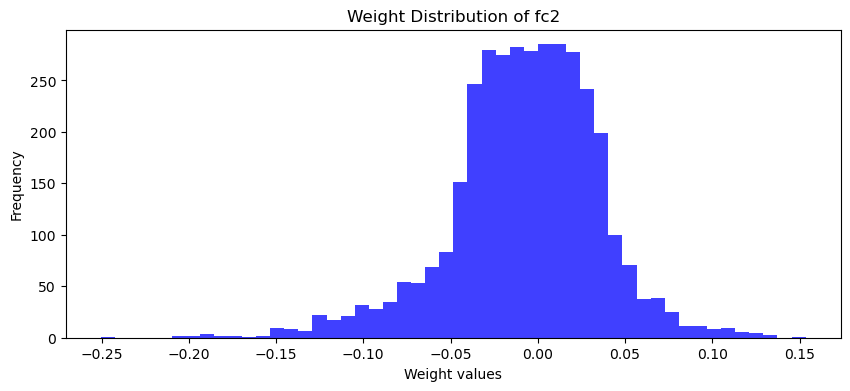

In [39]:
# Visualize weights of fc2
plot_layer_weights(mel_model.fc2, 'Weight Distribution of fc2')